In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
df_photo = pd.read_csv('./data/stripe82candidateVar_v1.1.dat',skiprows=5, header=1,index_col=0,sep='\s+')

In [3]:
#df_photo.head()

In [4]:
colnames = ['ID','Priority','Flags','Teff','eTeff','NTeff','logg','elogg','Nlogg','Z','eZ','NZ']
df_spec = pd.read_csv('./data/t3.txt',sep='\s+',skiprows=26,header=None,index_col=0,names=colnames)

In [5]:
#Combine both datasets 
df = pd.merge(df_spec, df_photo, on='ID',how='left')

In [6]:
df.head()

,Priority,Flags,Teff,eTeff,NTeff,logg,elogg,Nlogg,Z,eZ,...,ri,iz,gN,gAmpl,rN,rAmpl,iN,iAmpl,zQSO,MiQSO
ID,,,,,,,,,,,,,,,,,,,,,
4172970,4.0,nnnnn,5499.7,94.7,7,3.94,0.18,6,0.01,0.12,...,0.13,0.07,29,0.197,27,0.156,27,0.231,-9.9,-9.9
4583821,5.0,Nnnnn,4487.8,120.3,3,4.19,0.26,2,-0.95,0.08,...,0.30,0.16,50,0.124,49,0.106,51,0.094,-9.9,-9.9
4651452,2.0,NnBnX,-9999.0,-9999.0,0,-9999.00,-9999.00,0,-9999.00,-9999.00,...,-0.06,0.26,36,0.505,33,0.460,27,1.150,-9.9,-9.9
4777216,9.0,nnnnX,-9999.0,-9999.0,0,-9999.00,-9999.00,0,-9999.00,-9999.00,...,0.10,0.02,47,0.133,47,0.394,47,0.154,-9.9,-9.9
5302673,9.0,nnnnn,5986.7,161.8,4,3.93,0.79,2,-0.76,0.09,...,0.13,-0.05,36,0.332,33,0.175,39,0.253,-9.9,-9.9


In [7]:
df.columns

Index(['Priority', 'Flags', 'Teff', 'eTeff', 'NTeff', 'logg', 'elogg', 'Nlogg',
       'Z', 'eZ', 'NZ', 'ra', 'dec', 'P', 'r', 'ug', 'gr', 'ri', 'iz', 'gN',
       'gAmpl', 'rN', 'rAmpl', 'iN', 'iAmpl', 'zQSO', 'MiQSO'],
      dtype='object')

In [8]:
# Cleaning the training set not clearly mentioned in the paper. 
#Usign the entire dataset for now
#df = df[(df['Flags'] != 'nnnnn') & (df[Z] > -3.0)]

# Neural Network

In [9]:
df_nonan = df[df['Teff'] != -9999.0]

In [25]:
len(df_nonan)

3960

In [10]:
df_Y = df_nonan['Teff']

In [11]:
#Using just photometry and no light curve information
df_X = df_nonan[['ug','gr','ri','iz']]

In [12]:
train_X, test_X, train_y, test_y = train_test_split(df_X, df_Y, random_state=1, test_size=0.25)

In [13]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ug,2970.0,1.607599,0.507682,-0.05,1.19,1.48,1.97,3.19
gr,2970.0,0.605354,0.282562,-0.23,0.41,0.54,0.77,1.41
ri,2970.0,0.213303,0.137128,-0.27,0.13,0.18,0.27,1.22
iz,2970.0,0.080121,0.098160,-0.29,0.01,0.06,0.13,0.71


In [14]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_X)
normed_test_data = norm(test_X)

In [18]:
"""
model_temp = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1)
])
"""

model_temp = keras.Sequential([
    keras.layers.Flatten(input_shape=(len(train_X.columns),)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
])

In [19]:
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [20]:
model_temp.compile(optimizer=adm,
              loss='mse',
              metrics=['mse','mape'])

In [21]:
example_batch = normed_train_data[:10]
example_result = model_temp.predict(example_batch)
example_result

array([[ 0.03820833],
       [ 0.06348843],
       [-0.3866602 ],
       [ 0.0272007 ],
       [-0.03295853],
       [-0.3849567 ],
       [ 0.07413974],
       [-0.6715499 ],
       [ 0.05467436],
       [ 0.09724782]], dtype=float32)

In [22]:
history = model_temp.fit(normed_train_data, train_y, epochs=20, batch_size=32, validation_split = 0.15)

Train on 2524 samples, validate on 446 samples
Epoch 1/20
2524/2524 [==============================] - 0s 155us/sample - loss: 29439666.1014 - mse: 29439672.0000 - mape: 99.9157 - val_loss: 29584702.6637 - val_mse: 29584706.0000 - val_mape: 99.7295
Epoch 2/20
2524/2524 [==============================] - 0s 69us/sample - loss: 28899863.0460 - mse: 28899860.0000 - mape: 98.9890 - val_loss: 28470812.1525 - val_mse: 28470812.0000 - val_mape: 97.8444
Epoch 3/20
2524/2524 [==============================] - 0s 31us/sample - loss: 26801209.1981 - mse: 26801214.0000 - mape: 95.2737 - val_loss: 25259883.4350 - val_mse: 25259880.0000 - val_mape: 92.1389
Epoch 4/20
2524/2524 [==============================] - 0s 32us/sample - loss: 22293259.5594 - mse: 22293260.0000 - mape: 86.6092 - val_loss: 19624071.6233 - val_mse: 19624072.0000 - val_mape: 80.9242
Epoch 5/20
2524/2524 [==============================] - 0s 33us/sample - loss: 15906292.6450 - mse: 15906293.0000 - mape: 72.2673 - val_loss: 129418

In [23]:
loss, mae, mse = model_temp.evaluate(normed_test_data, test_y)

990/990 [==============================] - 0s 21us/sample - loss: 371084.0984 - mse: 371084.0625 - mape: 8.9224


(3000.0, 10000.0)

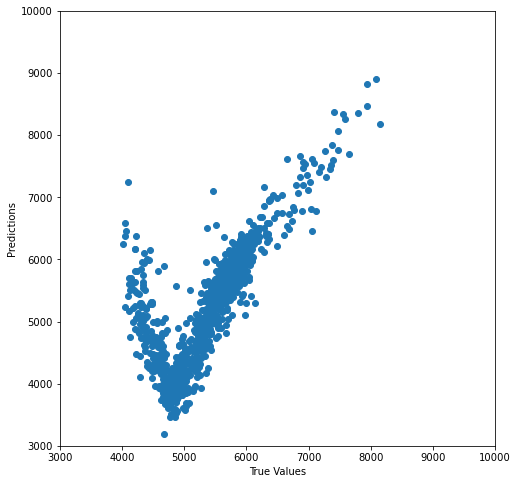

In [24]:
test_predictions = model_temp.predict(normed_test_data).flatten()

fig = plt.figure(1,figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

ax.scatter(test_y, test_predictions)
ax.set_xlabel('True Values')
ax.set_ylabel('Predictions')
ax.set_xlim(3000,10000)
ax.set_ylim(3000,10000)
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)